# This is to test the use of postgres in python using psycopg2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [4]:
conn = psycopg2.connect(
    host="localhost",
    database="ace_insight",
    user="postgres",
    password="postgres",
    port=5432
)

In [5]:
# Show which PCEs have a statistically significant protective effect (p < 0.05 and aOR < 1) for people with 1+ ACEs

query = """
SELECT 
    p.pce_name,
    o.outcome_name,
    sr.sex,
    COUNT(*) AS significant_cases,
    ROUND(AVG(sr.aor), 2) AS avg_aor
FROM resilience_factors.study_results sr
JOIN resilience_factors.pce_types p ON sr.pce_type_id = p.pce_type_id
JOIN resilience_factors.outcomes o ON sr.outcome_id = o.outcome_id
JOIN resilience_factors.ace_groups ag ON sr.ace_group_id = ag.ace_group_id
WHERE ag.ace_group_label = '1+ ACEs'
  AND sr.p_value IS NOT NULL
  AND sr.p_value <= 0.05
  AND sr.aor < 1
GROUP BY p.pce_name, o.outcome_name, sr.sex
ORDER BY avg_aor ASC;
"""

df = pd.read_sql_query(query, conn)
print(df)

                           pce_name        outcome_name     sex  \
0  Strong father–child relationship  Suicidal/self-harm    Male   
1  Strong mother–child relationship  Suicidal/self-harm    Male   
2  Strong father–child relationship       Substance use    Male   
3  Strong mother–child relationship       Substance use  Female   
4  Strong mother–child relationship  Suicidal/self-harm  Female   
5  Strong mother–child relationship     Mental distress  Female   

   significant_cases  avg_aor  
0                  1      0.4  
1                  1      0.5  
2                  1      0.6  
3                  1      0.6  
4                  1      0.6  
5                  1      0.7  


C:\Users\Nash\AppData\Local\Temp\ipykernel_13464\2896141795.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


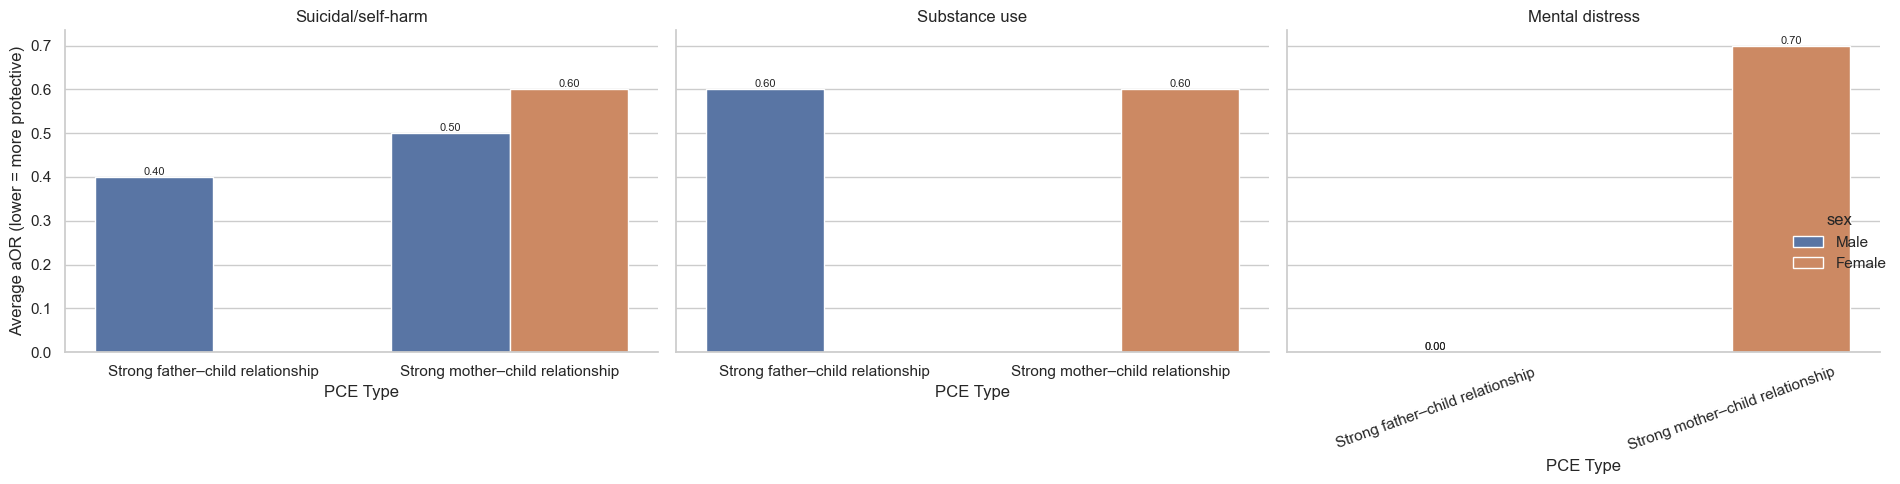

In [6]:
# -----------------------------
# 2. Plot settings
# -----------------------------
sns.set(style="whitegrid")

g = sns.catplot(
    data=df,
    kind="bar",
    x="pce_name",
    y="avg_aor",
    hue="sex",
    col="outcome_name",
    height=5,
    aspect=1.2
)

# Add value labels for avg_aor + significant_cases
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=8)

# Axis & title formatting
g.set_axis_labels("PCE Type", "Average aOR (lower = more protective)")
g.set_titles("{col_name}")
plt.xticks(rotation=20)
plt.tight_layout()

plt.show()